# Camera Configuration Diagnostics

The purpose of this notebook is to examine the accuracy of the camera array configuration both before and after bundle adjustment. It will import the pickled bundle adjustment data for inspection.

Begin by importing the pickled objects.

In [3]:
from pathlib import Path
import pickle
import sys

# some convenient reference paths
repo = str(Path.cwd()).split("src")[0]
# update path
sys.path.insert(0,repo)
# which enables import of relevant class
from src.cameras.camera_array import ArrayDiagnosticData

calibration_directory = Path(repo, "sessions", "iterative_adjustment", "recording")

before_path = Path(calibration_directory,"before_bund_adj.pkl")
after_path = Path(calibration_directory,"after_bund_adj.pkl")

with open(before_path, "rb") as file:
    before = pickle.load(file)

with open(after_path, "rb") as file:
    after = pickle.load(file)
    

In [24]:
    
import numpy as np
import pandas as pd

def create_summary_df(array_data:ArrayDiagnosticData, label):
    array_data_xy_error = array_data.xy_reprojection_error.reshape(-1,2)
    # build out error as singular distanc
    euclidean_distance_error = np.sqrt(np.sum(array_data_xy_error ** 2, axis=1))
    row_count = euclidean_distance_error.shape[0]
    array_data_dict = {
        "label": [label]*row_count,
        "camera": array_data.point_data.camera_indices_full.tolist(),
        "sync_index": array_data.point_data.sync_indices.tolist(),
        "charuco_id": array_data.point_data.corner_id.tolist(),
        "img_x": array_data.point_data.img_full[:,0].tolist(), 
        "img_y": array_data.point_data.img_full[:,1].tolist(), 
        "reproj_error_x": array_data_xy_error[:, 0].tolist(),
        "reproj_error_y": array_data_xy_error[:, 1].tolist(),
        "reproj_error": euclidean_distance_error.tolist(),
        "obj_id": array_data.point_data.obj_indices.tolist(),
        "obj_x": array_data.point_data.obj[array_data.point_data.obj_indices_full][:,0].tolist(),
        "obj_y": array_data.point_data.obj[array_data.point_data.obj_indices_full][:,1].tolist(),
        "obj_z": array_data.point_data.obj[array_data.point_data.obj_indices_full][:,2].tolist(),
    
    }

    array_data_df = pd.DataFrame(array_data_dict)
    return array_data_df

before_df = create_summary_df(before, "before")
after_df = create_summary_df(after, "after")

before_and_after = pd.concat([before_df, after_df])


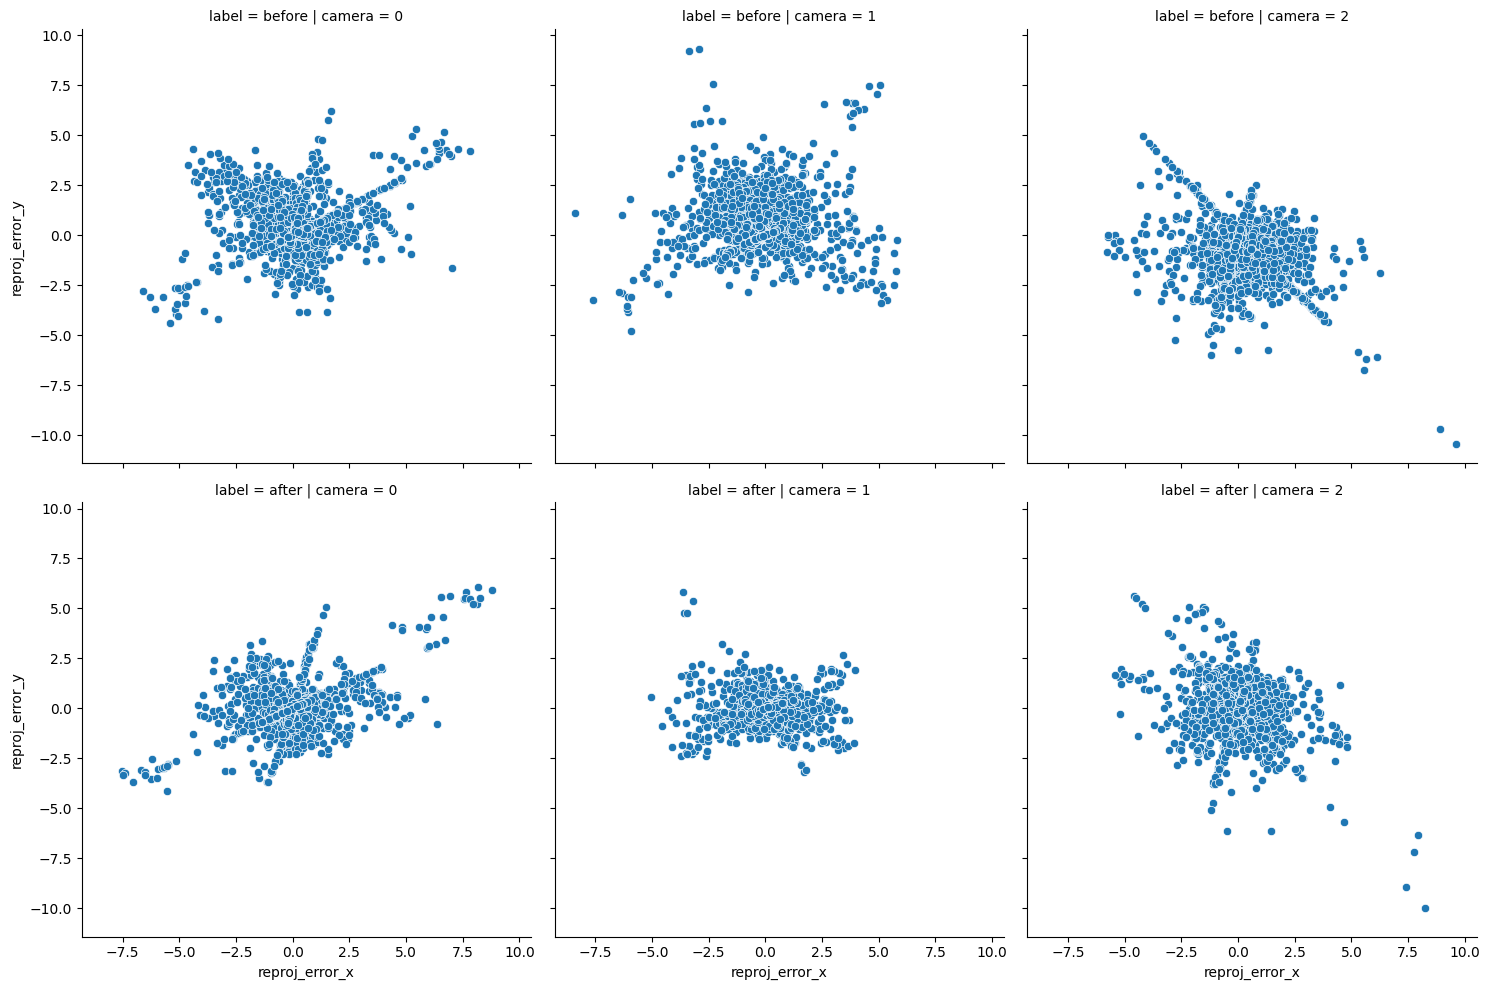

In [26]:
import seaborn as sns

sns.relplot(
    data= before_and_after,
    x="reproj_error_x",
    y="reproj_error_y",
    col="camera",
    row="label",
    kind="scatter",
)

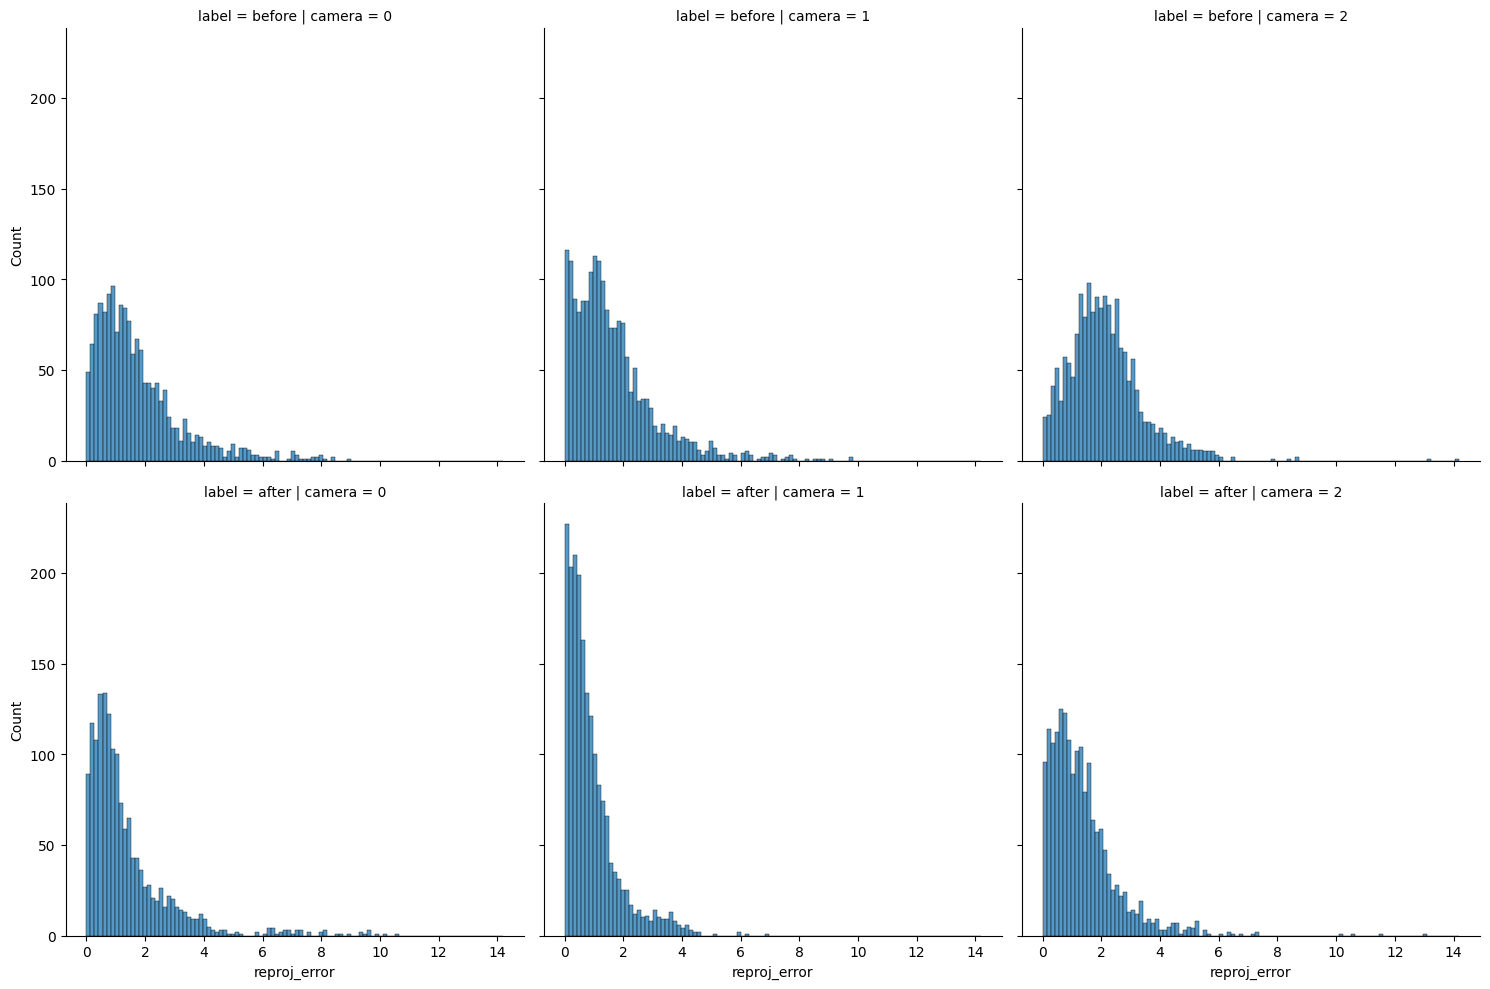

In [29]:

sns.displot(
    data= before_and_after,
    x="reproj_error",
    col="camera",
    row="label",
)

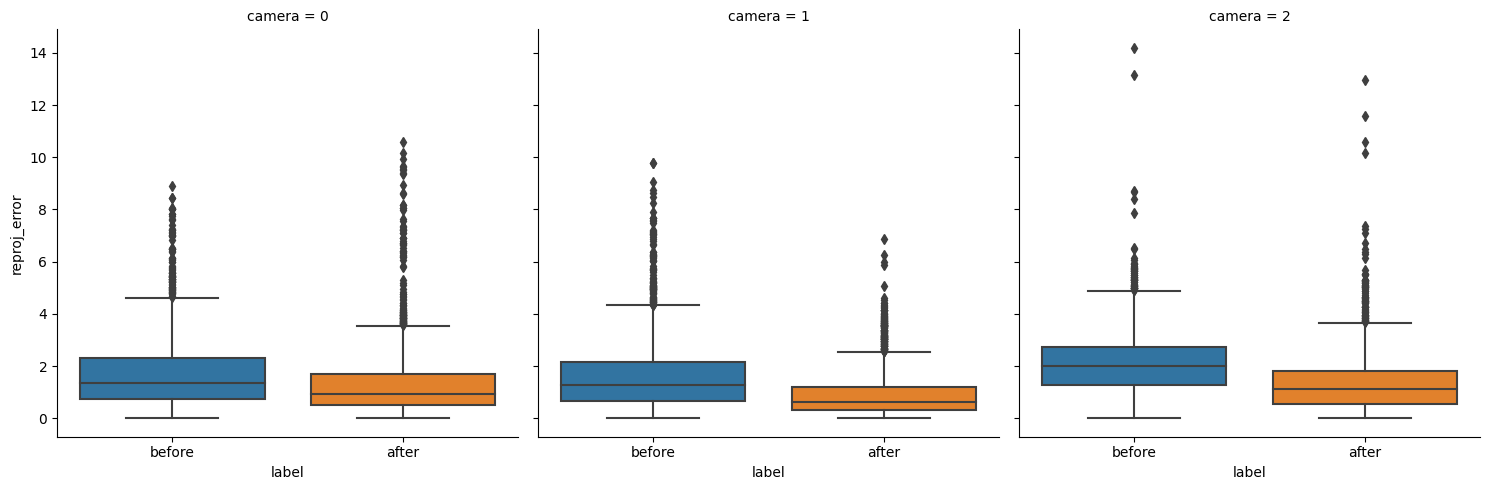

In [35]:
sns.catplot(
    data=before_and_after, 
    x="label", 
    y="reproj_error", 
    col="camera", 
    kind="box"
)